![](https://images.aicrowd.com/raw_images/challenges/banner_file/1021/e6d6bda6dc16f4905124.png)

<h2><center>Starter Code for Face Recognition</center></h2>


In this baseline we will be using basic [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)
 to compare the missing person image to all target faces ans generate our predictions. 

## Downloading Dataset

Installing puzzle datasets via `aicrowd-cli`

In [1]:
!pip install aicrowd-cli

# Make sure to re-run below code whenever you restart colab notebook
%load_ext aicrowd.magic

In [2]:
# Logging in from our AIcrowd account. Make sure you have accepted the puzzle rules before logging in!  

%aicrowd login

Please login here: https://api.aicrowd.com/auth/_lj-YE7GikTanbcdWpKLRLrQJJE3UQMQURoI0ACjZP4
API Key valid
Gitlab access token valid
Saved details successfully!


In [3]:
# Creating a new data directory and downloading the dataset 

!rm -rf data
!mkdir data
%aicrowd ds dl -c face-recognition -o data

data.zip:   0%|          | 0.00/747M [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

In [4]:
# unzipping the data

!unzip data/data.zip -d /content/data > /dev/null

## Importing Libraries

In [5]:
import pandas as pd
import os
import numpy as np
import random
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
import cv2


## Reading Dataset

In [6]:
# Getting all image ids from a folder

image_ids = os.listdir("data/missing")
len(image_ids)

1000

In [7]:
# We can also split all the faces in the target image to convert them into individual faces images

sample_target_faces = []


def get_target_face(face_no, target_image):


  # Top-Left x, y corrdinates of the specific face 
  x, y = (int(face_no[0]))*216, (int(face_no[1]))*216

  target_face = target_image[x:x+216, y:y+216]

  return target_face

## Generating Predictions

In [8]:
!pip install face-recognition

     |████████████████████████████████| 100.1 MB 29 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=5d0bd76bebd99ede0b3cce4ae51301800b825df3b9285d9844bf084bd6735781
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [9]:
import cv2
import numpy as np
import math
import face_recognition

predictions = {"ImageID":[], "target":[]}

# Find for every missing image a target image
for img_id in tqdm(image_ids):

  # Face no with minimum error
  min_error_face_no = 0
  min_distance = 100000000

  try:
    missing_image = face_recognition.load_image_file("data/missing/"+ img_id)
    missing_encoding_small = face_recognition.face_encodings(missing_image, num_jitters=2, model='small')[0]
    missing_encoding_large = face_recognition.face_encodings(missing_image, num_jitters=2, model='large')[0]

    target_image_original = cv2.imread("data/target/"+ img_id, 1)
    target_distances = []
    for face_no in range(100):
      # Getting the specific face from the target image
      face_no = str(face_no)
      face_no = face_no.zfill(2)

      single_target_face = get_target_face(face_no, target_image_original) # get one single image
      cv2.imwrite("tmp_target_face.jpg", single_target_face) # save cv image

      try:
        target_image = face_recognition.load_image_file("tmp_target_face.jpg") # load image
        target_encodings_small = face_recognition.face_encodings(target_image, num_jitters=2, model='small')
        target_encodings_large = face_recognition.face_encodings(target_image, num_jitters=2, model='large')

        # It could be that there are multiple faces in one image
        # We are using both: The small and the large model to find the best target over all
        min_distance_small = min_distance
        for target_encoding in target_encodings_small:
          face_distance = face_recognition.face_distance([missing_encoding_small], target_encoding)
          # We want the smallest distance in this picture for small model
          if face_distance < min_distance_small:
            min_distance_small = face_distance

        min_distance_large = min_distance
        for target_encoding in target_encodings_large:
          face_distance = face_recognition.face_distance([missing_encoding_large], target_encoding)
          # We want the smallest distance in this picture for large model
          if face_distance < min_distance_large:
            min_distance_large = face_distance

        # Add distance mean to target_distance list
        target_distances.append( (min_distance_small + min_distance_large) /2 )


      except:
        print("The facereconition went wrong for a target image")
        target_image_tmp = cv2.imread("tmp_target_face.jpg")
        cv2_imshow(target_image_tmp)

    # The target face with the minimal distance is the searched for
    min_error_face_no = str(target_distances.index(min(target_distances)))
    min_error_face_no = min_error_face_no.zfill(2)
  except:
    print("The facereconition went wrong for a missing image")
    
  predictions['ImageID'].append(img_id.replace(".jpg", ""))
  predictions['target'].append(min_error_face_no)
  



  0%|          | 0/1000 [00:00<?, ?it/s]

The facereconition went wrong for a missing image
The facereconition went wrong for a missing image


Missing: a74x0



--------Target--------
75


----------------------

Missing: rh6dw


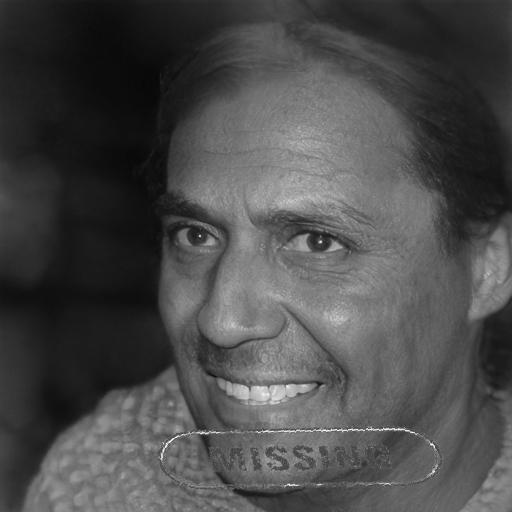


--------Target--------
37


----------------------



In [11]:
# ---- Visualize above
for i in range(len(predictions['ImageID'][:2])):
  print("Missing: "+ predictions['ImageID'][i])
  file_name = predictions['ImageID'][i] + ".jpg"
  missing_image = cv2.imread(os.path.join("data/missing", file_name), 0)
  cv2_imshow(missing_image)

  print()
  print("--------Target--------")
  print(predictions['target'][i])
  target_image = cv2.imread(os.path.join("data/target", file_name), 0)
  sample_target_face = get_target_face(str(predictions['target'][i]), target_image)
  cv2_imshow(sample_target_face)

  print("----------------------")
  print()


In [13]:
submission = pd.DataFrame(predictions)
submission

ImageID target
0     a74x0     75
1     rh6dw     37
2     3whr1     05
3     uprjf     78
4     sr232     28
..      ...    ...
995   ad65t     63
996   1v7to     50
997   61xtk     64
998   kag99     19
999   mvcco     66

[1000 rows x 2 columns]

### Saving the Predictions

In [14]:
# Saving the predictions
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"), index=False)

## Submitting our Predictions

In [ ]:
%aicrowd notebook submit -c face-recognition -a assets --no-verify

Congratulations to making your first submission in the puzzle 🎉  . Let's continue with the journey by improving the baseline & making submission! Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in discussion forum or in AIcrowd Discord sever, AIcrew will be happy to help you :)

Have a cool new idea that you want to see in the next blitz ? Let us know!